## Time Window Features

Run this notebook in Vertex Workbench. In this notebook, we will look at the behavior of delays over time.

The method used in this notebook violates causality constraints. We'll do time windows properly in Dataflow.

In [2]:
%load_ext bigquery_magics

## Delays at airport

What's the behavior of arrival delays at a specific airport?

In [46]:
%%bigquery dfw

SELECT
  dep_time,
  arr_delay
FROM dsongcp.flights_tzcorr
WHERE
  ORIGIN = 'DFW' AND FL_DATE = '2015-03-02' AND CANCELLED = False

Query is running:   0%|          |

Downloading:   0%|          |

In [47]:
dfw_plot = dfw.sort_values(by='dep_time').set_index('dep_time');
dfw_plot.head()

,arr_delay
dep_time,
2015-03-02 06:53:00+00:00,147.0
2015-03-02 06:53:00+00:00,147.0
2015-03-02 06:53:00+00:00,147.0
2015-03-02 11:09:00+00:00,-16.0
2015-03-02 11:09:00+00:00,-16.0


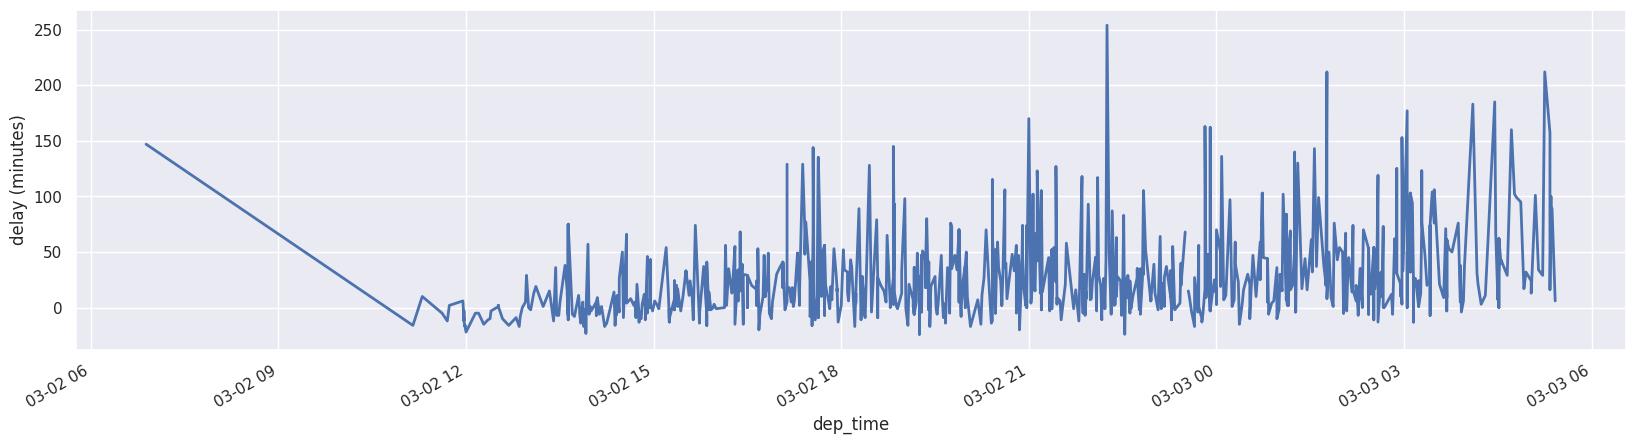

In [48]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(20, 5)})
ax = dfw_plot['arr_delay'].plot(linewidth=2);
ax.set_ylabel('delay (minutes)');

## Rolling average

What does the rolling average behave like?

In [50]:
%%bigquery dfw

SELECT
  dep_time,
  AVG(dep_delay) OVER time_window AS dep_delay,
  AVG(arr_delay) OVER time_window AS arr_delay
FROM dsongcp.flights_tzcorr
WHERE
  ORIGIN = 'DFW' AND FL_DATE = '2015-03-02' AND CANCELLED = False
WINDOW time_window AS (ORDER BY UNIX_SECONDS(dep_time) 
                       RANGE BETWEEN 3600 PRECEDING AND 1 PRECEDING)

Query is running:   0%|          |

Downloading:   0%|          |

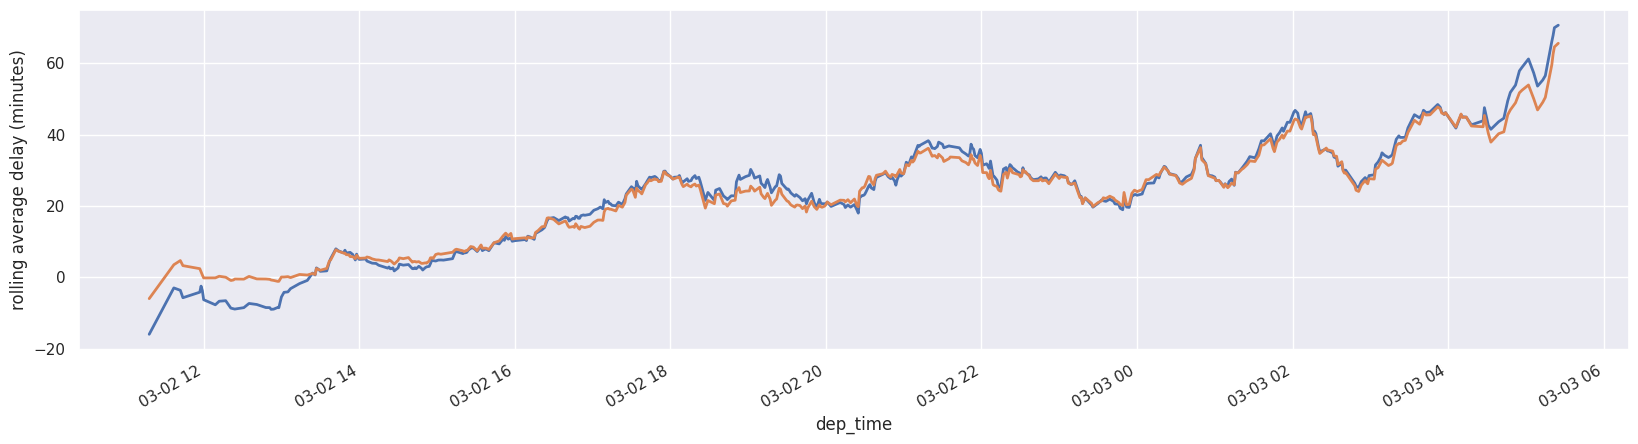

In [51]:
dfw_plot = dfw.sort_values(by='dep_time').set_index('dep_time');
ax = dfw_plot['arr_delay'].plot(linewidth=2);
dfw_plot['dep_delay'].plot(linewidth=2, ax=ax);
ax.set_ylabel('rolling average delay (minutes)');

## Taxiout by airport

Does taxi out time vary by airport? Is the same value of taxiout associated with late arrivals in one airport, but normal in another?

In [52]:
%%bigquery txout

SELECT
  ORIGIN,
  IF (arr_delay < 15, True, False) AS is_on_time,
  AVG(taxi_out) AS taxi_out
FROM dsongcp.flights_tzcorr
WHERE SUBSTR(ORIGIN, 1, 1) = 'D'
GROUP BY ORIGIN, is_on_time

Query is running:   0%|          |

Downloading:   0%|          |

In [53]:
txout.head()

,ORIGIN,is_on_time,taxi_out
0,DCA,True,16.708146
1,DTW,True,16.797770
2,DAY,False,19.702076
3,DCA,False,27.867031
4,DAB,False,18.649425


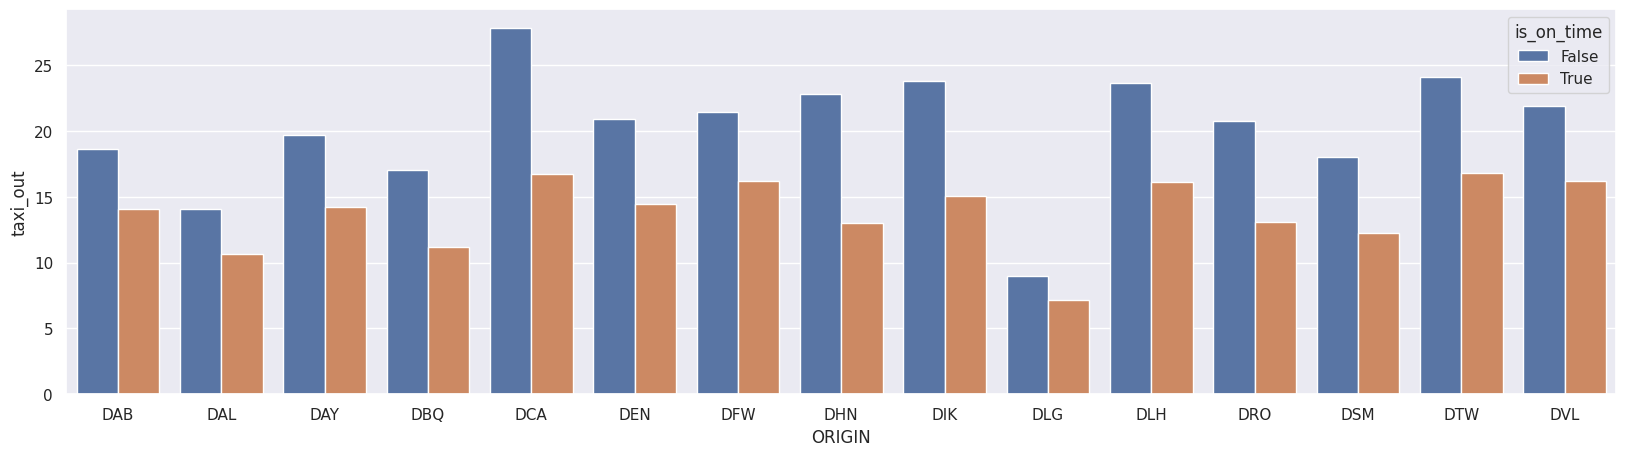

In [54]:
txout = txout.sort_values(by='ORIGIN')
sns.barplot(data=txout, x='ORIGIN', y='taxi_out', hue='is_on_time');

## Add new features

Let's add these two features and train an xgboost model

In [55]:
%%bigquery
WITH taxiout_by_airport AS (
   SELECT 
    ORIGIN, AVG(taxi_out) AS avg_taxi_out
   FROM
    dsongcp.flights_tzcorr
   GROUP BY ORIGIN
)

SELECT
  IF(arr_delay < 15, 'ontime', 'late') AS ontime,
  dep_delay,
  AVG(dep_delay) OVER (origin_time_window) AS avg_dep_delay,
  taxi_out,
  avg_taxi_out,
  distance,
  origin,
  dest,
  IF(is_train_day = 'True', False, True) AS is_eval_day
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
JOIN taxiout_by_airport USING(ORIGIN)
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False
WINDOW origin_time_window AS (PARTITION BY ORIGIN
                              ORDER BY UNIX_SECONDS(dep_time) 
                              RANGE BETWEEN 3600 PRECEDING AND 1 PRECEDING)

LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,ontime,dep_delay,avg_dep_delay,taxi_out,avg_taxi_out,distance,origin,dest,is_eval_day
0,ontime,-4.0,NaN,31.0,11.628895,359.0,AMA,DEN,False
1,ontime,-4.0,NaN,31.0,11.628895,359.0,AMA,DEN,False
2,ontime,-4.0,NaN,31.0,11.628895,359.0,AMA,DEN,False
3,ontime,-6.0,-4.0,18.0,11.628895,323.0,AMA,DAL,False
4,ontime,-6.0,-4.0,18.0,11.628895,323.0,AMA,DAL,False


In [56]:
%%bigquery
CREATE OR REPLACE MODEL dsongcp.arr_delay_airports_timefeatures
OPTIONS(input_label_cols=['ontime'], 
        model_type='boosted_tree_classifier',
        data_split_method='custom',
        data_split_col='is_eval_day')
AS

WITH taxiout_by_airport AS (
   SELECT 
    ORIGIN, AVG(taxi_out) AS avg_taxi_out
   FROM
    dsongcp.flights_tzcorr
   GROUP BY ORIGIN
)

SELECT
  IF(arr_delay < 15, 'ontime', 'late') AS ontime,
  dep_delay,
  AVG(dep_delay) OVER origin_time_window AS avg_dep_delay,
  taxi_out,
  avg_taxi_out,
  distance,
  origin,
  dest,
  IF(is_train_day = 'True', False, True) AS is_eval_day
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
JOIN taxiout_by_airport USING(ORIGIN)
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False
WINDOW origin_time_window AS (PARTITION BY ORIGIN
                              ORDER BY UNIX_SECONDS(dep_time) 
                              RANGE BETWEEN 3600 PRECEDING AND 1 PRECEDING)

Query is running:   0%|          |

""


In [57]:
%%bigquery

WITH predictions AS (
SELECT 
  *
FROM ML.PREDICT(MODEL dsongcp.arr_delay_airports_timefeatures,
                 (
WITH taxiout_by_airport AS (
   SELECT 
    ORIGIN, AVG(taxi_out) AS avg_taxi_out
   FROM
    dsongcp.flights_tzcorr
   GROUP BY ORIGIN
)
SELECT
  IF(arr_delay < 15, 'ontime', 'late') AS ontime,
  dep_delay,
  AVG(dep_delay) OVER origin_time_window AS avg_dep_delay,
  taxi_out,
  avg_taxi_out,
  distance,
  origin,
  dest,
  IF(is_train_day = 'True', False, True) AS is_eval_day
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
JOIN taxiout_by_airport USING(ORIGIN)
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  t.is_train_day = 'False'
WINDOW origin_time_window AS (PARTITION BY ORIGIN
                              ORDER BY UNIX_SECONDS(dep_time) 
                              RANGE BETWEEN 3600 PRECEDING AND 1 PRECEDING)
                 ),
                 STRUCT(0.7 AS threshold))),

stats AS (
SELECT 
  COUNTIF(ontime != 'ontime' AND ontime = predicted_ontime) AS correct_cancel
  , COUNTIF(predicted_ontime = 'ontime') AS total_noncancel
  , COUNTIF(ontime = 'ontime' AND ontime = predicted_ontime) AS correct_noncancel
  , COUNTIF(ontime != 'ontime') AS total_cancel
  , SQRT(SUM((IF(ontime = 'ontime', 1, 0) - p.prob) * (IF(ontime = 'ontime', 1, 0) - p.prob))/COUNT(*)) AS rmse
FROM predictions, UNNEST(predicted_ontime_probs) p
WHERE p.label = 'ontime'
)

SELECT
   correct_cancel / total_cancel AS correct_cancel
   , total_noncancel
   , correct_noncancel / total_noncancel AS correct_noncancel
   , total_cancel
   , rmse
FROM stats

Query is running:   0%|          |

Downloading:   0%|          |

,correct_cancel,total_noncancel,correct_noncancel,total_cancel,rmse
0,0.842838,3917532,0.965837,851562,0.20404


Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.